In [1]:
import gc
import glob
import pandas
import numpy as np

from datetime import datetime
from lightgbm.sklearn import LGBMRanker

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

In [2]:
# ----- Функции подготовки датасета для обучения -----

In [3]:
def prepareV1(df):
    _ = df.copy()
    _['session_length'] = _.groupby('session')['ts'].transform('count')
    _['action_num_reverse_chrono'] = _.session_length - _.groupby('session').cumcount() - 1
    linear_interpolation = 0.1 + ((1-0.1) / (_['session_length']-1)) * (_['session_length']-_['action_num_reverse_chrono']-1)
    _['log_recency_score'] = (2 ** linear_interpolation - 1).fillna(1.0)
    _['type_weighted_log_recency_score'] = _['log_recency_score'] / _['type'].map({0:1, 1:6, 2:3})
    _['bought_in_session'] = _['type'].map({0:1, 1:2, 2:0})
    return _
# --------------------
def getFeaturesV1():
    return ['type', 'action_num_reverse_chrono', 'session_length', 'log_recency_score', 'type_weighted_log_recency_score',
            'session', 'aid', 'bought_in_session']
# --------------------------------------------------------------------------------------------------------
def prepareV2(df):
    _ = df.copy()
    _['session_length'] = _.groupby('session')['ts'].transform('count')
    item_features = _.groupby('aid').agg({'aid':'count','session':'nunique','type':'mean'})
    item_features.columns = ['item_item_count','item_user_count','item_buy_ratio']
    item_features = item_features.astype({'item_item_count': 'uint16', 'item_user_count': 'uint16', 'item_buy_ratio':'float32'})
    user_features = _.groupby('session').agg({'session':'count','aid':'nunique','type':'mean'})
    user_features.columns = ['user_user_count','user_item_count','user_buy_ratio']
    user_features = user_features.astype({'user_user_count': 'uint16', 'user_item_count': 'uint16', 'user_buy_ratio':'float32'})
    _ = _.merge(item_features, how='left', right_index=True, left_on='aid')
    _ = _.merge(user_features, how='left', right_index=True, left_on='session')
    return _
# --------------------
def getFeaturesV2():
    return ['type', 'item_item_count', 'item_user_count', 'item_buy_ratio', 'user_user_count', 'user_item_count', 'user_buy_ratio']
# --------------------------------------------------------------------------------------------------------
def prepareV3(df):
    _ = df.copy()
    return _[_['type']!=0]

In [4]:
# ==================================================================
# ----- Конфигурация сессии для экспериментов-----------------------
# ==================================================================
LOCAL = False  # Тип метрики. True - локально, False - Kaggle
SAVE  = True # Сохранять ли файлы. Нужно при сохранении датасета
SHOW  = True # Выводить ли таблицы в процессе
GPU   = False # Использовать GPU
# -----------------------------------------------------------------
params = {
    'model': LGBMRanker,
    'params': {
        'objective':"lambdarank",
        'boosting_type':"dart",
        'n_estimators': 20,
        'learning_rate': 0.1,
    },
    'pipeline': [prepareV1],
    'features': list(set(getFeaturesV1())),
    'target': 'gt'
}
# ----------------------------------------------------
if GPU: import cudf
pd = cudf if GPU else pandas
print('We will use RAPIDS version',cudf.__version__) if GPU else print('We will use CPU', '...')

We will use CPU ...


In [5]:
%%time
# ~ 3s
train = pd.read_parquet('../input/otto-train-and-test-data-for-local-validation/test.parquet')
train_labels = pd.read_parquet('../input/otto-train-and-test-data-for-local-validation/test_labels.parquet')
if SHOW: display(train, train_labels)

,session,aid,ts,type
0,11098528,11830,1661119200,0
1,11098529,1105029,1661119200,0
2,11098530,264500,1661119200,0
3,11098530,264500,1661119288,0
4,11098530,409236,1661119369,0
...,...,...,...,...
7683572,12899774,33035,1661723968,0
7683573,12899775,1743151,1661723970,0
7683574,12899776,548599,1661723972,0
7683575,12899777,384045,1661723976,0


,session,type,ground_truth
0,11098528,clicks,[1679529]
1,11098528,carts,[1199737]
2,11098528,orders,"[990658, 950341, 1462506, 1561739, 907564, 369..."
3,11098529,clicks,[1105029]
4,11098530,orders,[409236]
...,...,...,...
2212687,12899774,clicks,[1399483]
2212688,12899775,clicks,[1760714]
2212689,12899776,clicks,[1737908]
2212690,12899777,clicks,[384045]


CPU times: user 1.42 s, sys: 1.22 s, total: 2.63 s
Wall time: 2.95 s


In [6]:
%%time
# ~ 3s
for func in params['pipeline']:
    train = func(train)
if SHOW: display(train)

,session,aid,ts,type,session_length,action_num_reverse_chrono,log_recency_score,type_weighted_log_recency_score,bought_in_session
0,11098528,11830,1661119200,0,1,0,1.000000,1.000000,1
1,11098529,1105029,1661119200,0,1,0,1.000000,1.000000,1
2,11098530,264500,1661119200,0,6,5,0.071773,0.071773,1
3,11098530,264500,1661119288,0,6,4,0.214195,0.214195,1
4,11098530,409236,1661119369,0,6,3,0.375542,0.375542,1
...,...,...,...,...,...,...,...,...,...
7683572,12899774,33035,1661723968,0,1,0,1.000000,1.000000,1
7683573,12899775,1743151,1661723970,0,1,0,1.000000,1.000000,1
7683574,12899776,548599,1661723972,0,1,0,1.000000,1.000000,1
7683575,12899777,384045,1661723976,0,1,0,1.000000,1.000000,1


CPU times: user 2.51 s, sys: 1.01 s, total: 3.53 s
Wall time: 3.53 s


In [7]:
%%time
# ~ 4s
train_labels = train_labels.explode('ground_truth')
train_labels = train_labels.rename(columns={'ground_truth': 'aid'})
train_labels['type'] = train_labels['type'].map({"clicks": 0, "carts": 1, "orders": 2})
train_labels['gt'] = 1
train_labels['aid'] = train_labels['aid'].astype('int32')
train_labels['gt'] = train_labels['gt'].astype('float32')
train_labels['type'] = train_labels['type'].astype('uint8')
train_labels['session'] = train_labels['session'].astype('int32')
if SHOW: display(train_labels)

,session,type,aid,gt
0,11098528,0,1679529,1.0
1,11098528,1,1199737,1.0
2,11098528,2,990658,1.0
2,11098528,2,950341,1.0
2,11098528,2,1462506,1.0
...,...,...,...,...
2212687,12899774,0,1399483,1.0
2212688,12899775,0,1760714,1.0
2212689,12899776,0,1737908,1.0
2212690,12899777,0,384045,1.0


CPU times: user 3.46 s, sys: 404 ms, total: 3.87 s
Wall time: 3.84 s


In [8]:
%%time
# ~ 6s
train = train.merge(train_labels, on=['session', 'type', 'aid'], how='left')
train['gt'] = train['gt'].fillna(0)
train = train.sort_values('session').reset_index(drop=True)
if SHOW: display(train)

,session,aid,ts,type,session_length,action_num_reverse_chrono,log_recency_score,type_weighted_log_recency_score,bought_in_session,gt
0,11098528,11830,1661119200,0,1,0,1.000000,1.000000,1,0.0
1,11098529,1105029,1661119200,0,1,0,1.000000,1.000000,1,1.0
2,11098530,264500,1661119200,0,6,5,0.071773,0.071773,1,0.0
3,11098530,264500,1661119288,0,6,4,0.214195,0.214195,1,0.0
4,11098530,409236,1661119369,0,6,3,0.375542,0.375542,1,0.0
...,...,...,...,...,...,...,...,...,...,...
7683572,12899774,33035,1661723968,0,1,0,1.000000,1.000000,1,0.0
7683573,12899775,1743151,1661723970,0,1,0,1.000000,1.000000,1,0.0
7683574,12899776,548599,1661723972,0,1,0,1.000000,1.000000,1,0.0
7683575,12899777,384045,1661723976,0,1,0,1.000000,1.000000,1,1.0


CPU times: user 5.54 s, sys: 1.53 s, total: 7.07 s
Wall time: 7.09 s


In [9]:
def get_session_lengths(df):
    return df.groupby('session')['session_length'].count().sort_index().values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    train, train[params['target']], train_size=0.7, test_size=0.3, random_state=0)

In [11]:
ranker = params['model'](**params['params'], verbose=-1, importance_type='gain', force_col_wise=True)
ranker

LGBMRanker(boosting_type='dart', force_col_wise=True, importance_type='gain',
           n_estimators=20, objective='lambdarank', verbose=-1)

In [12]:
params['features']

['type_weighted_log_recency_score',
 'session',
 'action_num_reverse_chrono',
 'aid',
 'bought_in_session',
 'session_length',
 'log_recency_score',
 'type']

In [13]:
%%time
# ~ 20s
ranker = ranker.fit(
    X_train[params['features']], y_train,
    group=get_session_lengths(X_train),
    eval_set=[(X_valid[params['features']], y_valid),(X_train[params['features']], y_train)],
    eval_group=[get_session_lengths(X_valid), get_session_lengths(X_train)],
)

[1]	valid_0's ndcg@1: 0.929399	valid_0's ndcg@2: 0.947565	valid_0's ndcg@3: 0.955615	valid_0's ndcg@4: 0.959657	valid_0's ndcg@5: 0.961938	valid_1's ndcg@1: 0.88854	valid_1's ndcg@2: 0.910443	valid_1's ndcg@3: 0.921939	valid_1's ndcg@4: 0.928535	valid_1's ndcg@5: 0.932702
[2]	valid_0's ndcg@1: 0.929815	valid_0's ndcg@2: 0.947834	valid_0's ndcg@3: 0.955841	valid_0's ndcg@4: 0.959849	valid_0's ndcg@5: 0.962103	valid_1's ndcg@1: 0.889194	valid_1's ndcg@2: 0.910867	valid_1's ndcg@3: 0.922297	valid_1's ndcg@4: 0.928868	valid_1's ndcg@5: 0.933039
[3]	valid_0's ndcg@1: 0.930245	valid_0's ndcg@2: 0.948124	valid_0's ndcg@3: 0.956084	valid_0's ndcg@4: 0.960085	valid_0's ndcg@5: 0.962318	valid_1's ndcg@1: 0.890061	valid_1's ndcg@2: 0.911399	valid_1's ndcg@3: 0.922687	valid_1's ndcg@4: 0.929242	valid_1's ndcg@5: 0.93338
[4]	valid_0's ndcg@1: 0.930281	valid_0's ndcg@2: 0.948133	valid_0's ndcg@3: 0.95607	valid_0's ndcg@4: 0.960059	valid_0's ndcg@5: 0.962306	valid_1's ndcg@1: 0.890424	valid_1's ndcg@

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

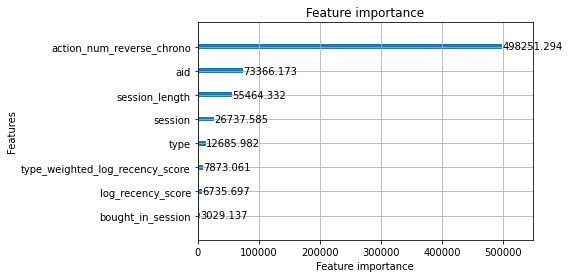

In [14]:
from lightgbm import plot_importance
plot_importance(ranker)

In [15]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(params['features'][i],'\t', '-'*10, '>\t', ranker.feature_importances_[i]/ranker.feature_importances_.sum())

action_num_reverse_chrono 	 ---------- >	 0.7282850293058024
aid 	 ---------- >	 0.10723802627134695
session_length 	 ---------- >	 0.08107122454559182
session 	 ---------- >	 0.039081850737032874
type 	 ---------- >	 0.018542873398834352
type_weighted_log_recency_score 	 ---------- >	 0.011507912208645187
log_recency_score 	 ---------- >	 0.009845448285684134
bought_in_session 	 ---------- >	 0.004427635247062238


/opt/conda/lib/python3.7/site-packages/lightgbm/plotting.py:372: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


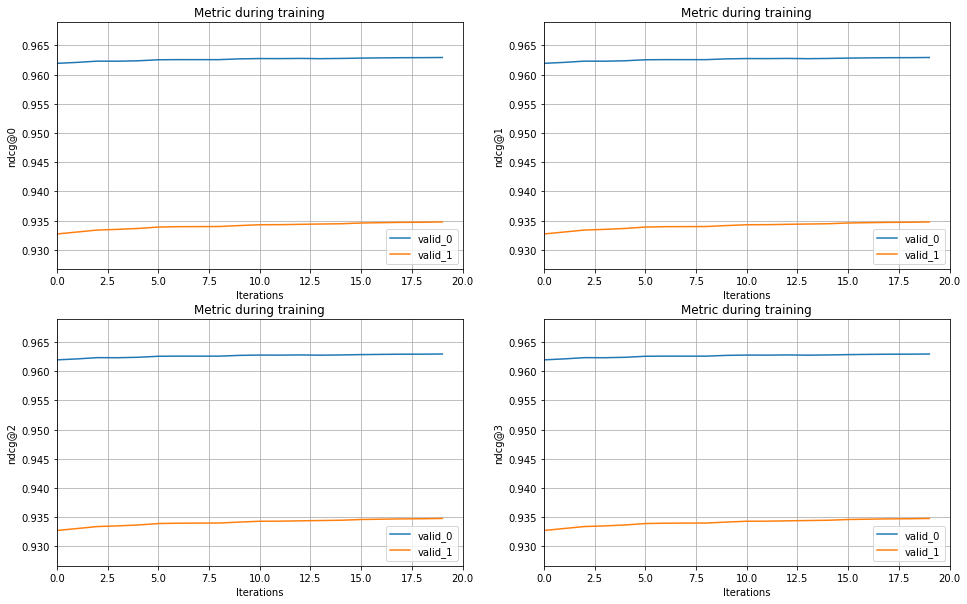

In [16]:
from lightgbm import plot_metric
import matplotlib.pyplot as plt
cols = 2
labels = 4
i, j = 0, 0
r = round(labels / cols)
_, ax = plt.subplots(r, cols, figsize=(16, 5*r))
for l in range(0, labels):
    qx = ax[j] if r == 1 else ax[i, j]
    plot_metric(ranker, xlabel='Iterations', ylabel=f'ndcg@{l}', ax=qx)
    j = j + 1
    i = i + 1 if j == cols else i
    j = 0 if j == cols else j

<AxesSubplot:>

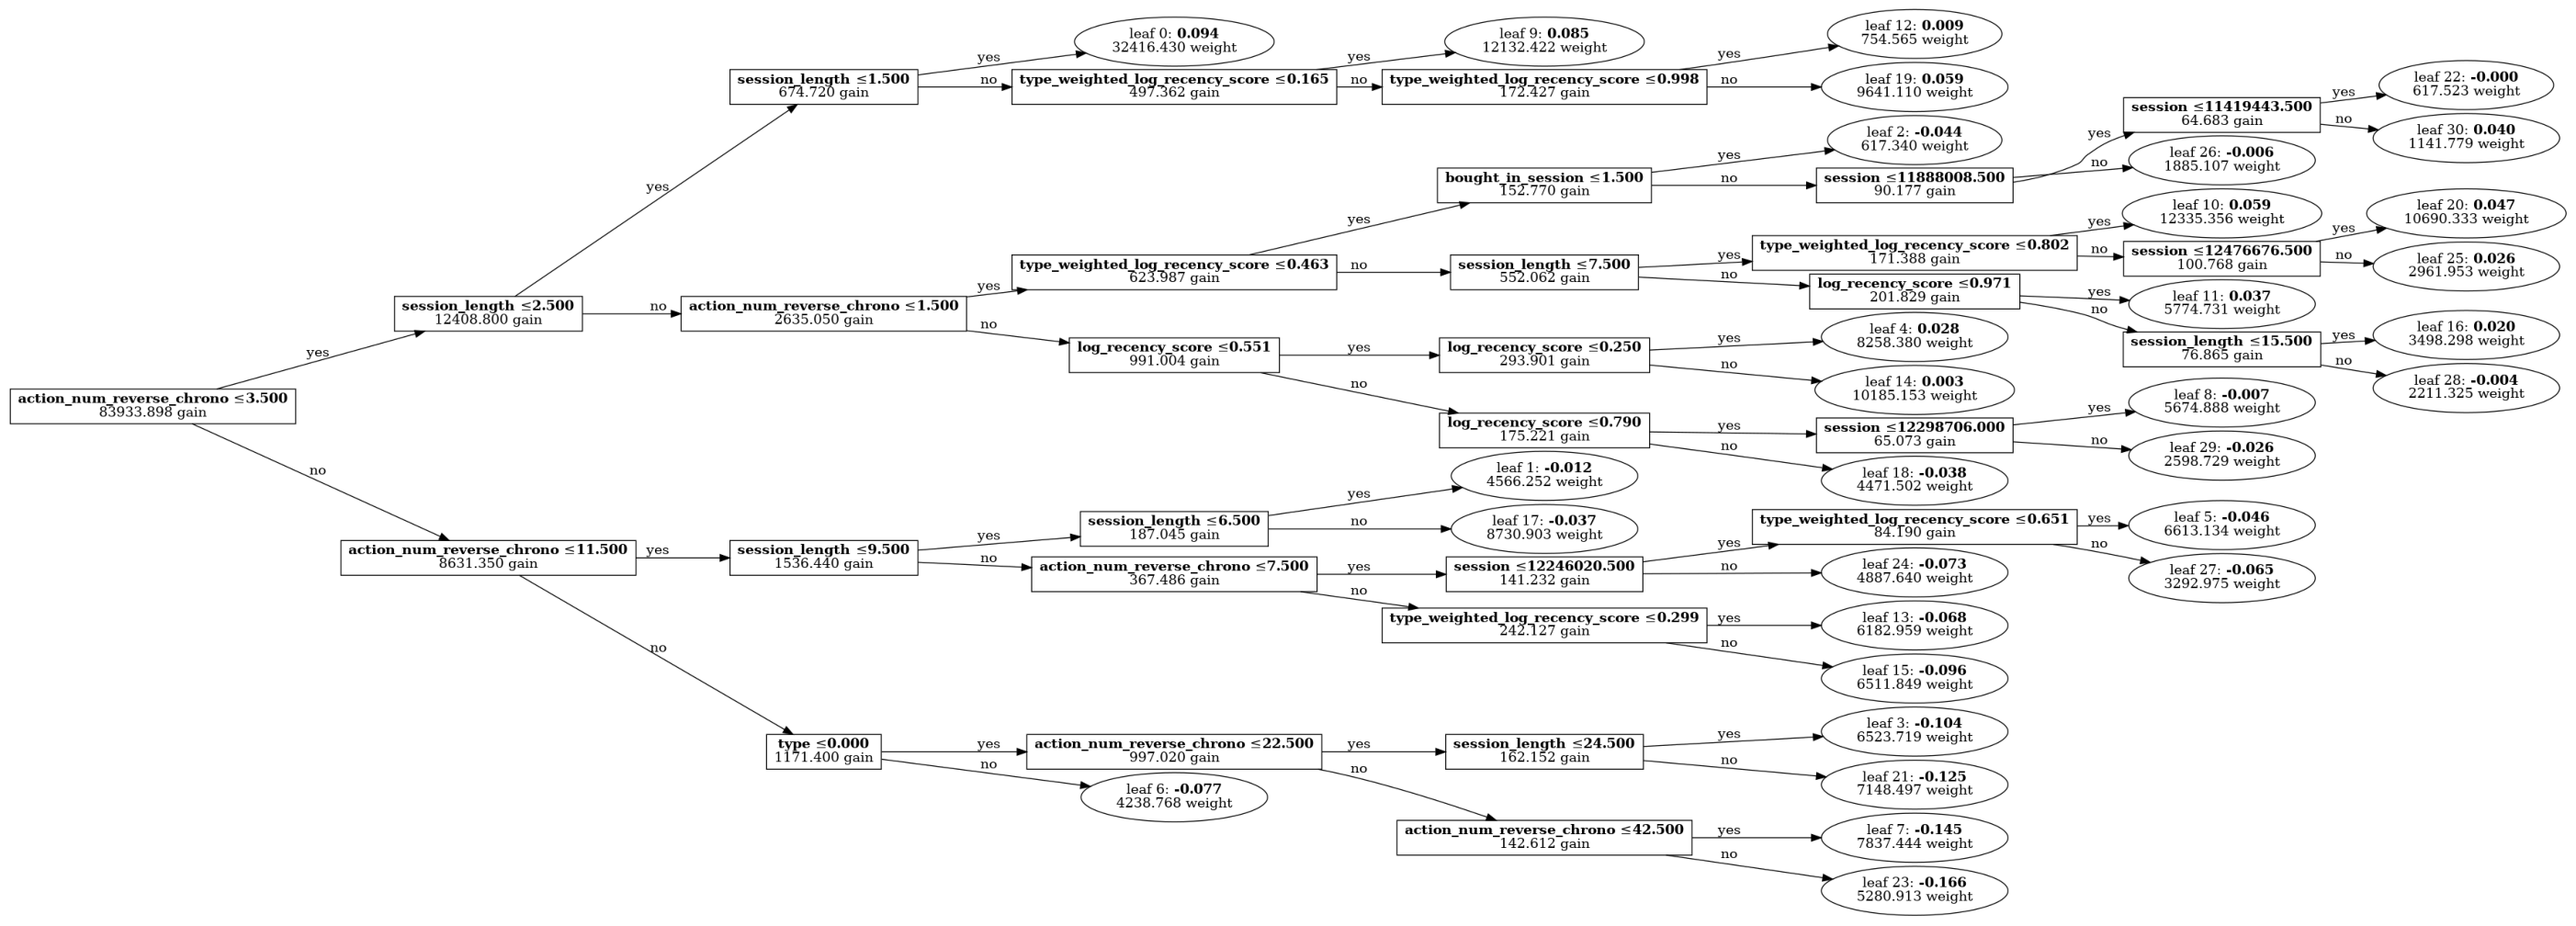

In [17]:
from lightgbm import plot_tree
plot_tree(ranker, figsize=(50, 50), show_info=['split_gain', 'leaf_weight'])

In [18]:
# ----- PREDICT -----

In [19]:
if LOCAL: 
    src = 'otto-train-and-test-data-for-local-validation'
else: 
    src = 'otto-full-optimized-memory-footprint'
    
test = pd.read_parquet(f'../input/{src}/test.parquet')
for func in params['pipeline']:
    test = func(test)
if SHOW: display(test)

,session,aid,ts,type,session_length,action_num_reverse_chrono,log_recency_score,type_weighted_log_recency_score,bought_in_session
0,12899779,59625,1661724000,0,1,0,1.000000,1.000000,1
1,12899780,1142000,1661724000,0,5,4,0.071773,0.071773,1
2,12899780,582732,1661724058,0,5,3,0.252664,0.252664,1
3,12899780,973453,1661724109,0,5,2,0.464086,0.464086,1
4,12899780,736515,1661724136,0,5,1,0.711190,0.711190,1
...,...,...,...,...,...,...,...,...,...
6928118,14571577,1141710,1662328774,0,1,0,1.000000,1.000000,1
6928119,14571578,519105,1662328775,0,1,0,1.000000,1.000000,1
6928120,14571579,739876,1662328775,0,1,0,1.000000,1.000000,1
6928121,14571580,202353,1662328781,0,1,0,1.000000,1.000000,1


In [20]:
scores = ranker.predict(test[params['features']])
test['score'] = scores
test

,session,aid,ts,type,session_length,action_num_reverse_chrono,log_recency_score,type_weighted_log_recency_score,bought_in_session,score
0,12899779,59625,1661724000,0,1,0,1.000000,1.000000,1,0.265088
1,12899780,1142000,1661724000,0,5,4,0.071773,0.071773,1,-0.225436
2,12899780,582732,1661724058,0,5,3,0.252664,0.252664,1,-0.103650
3,12899780,973453,1661724109,0,5,2,0.464086,0.464086,1,-0.143592
4,12899780,736515,1661724136,0,5,1,0.711190,0.711190,1,0.159133
...,...,...,...,...,...,...,...,...,...,...
6928118,14571577,1141710,1662328774,0,1,0,1.000000,1.000000,1,0.267999
6928119,14571578,519105,1662328775,0,1,0,1.000000,1.000000,1,0.267999
6928120,14571579,739876,1662328775,0,1,0,1.000000,1.000000,1,0.267999
6928121,14571580,202353,1662328781,0,1,0,1.000000,1.000000,1,0.265088


In [21]:
test_predictions = test.sort_values(by=['session', 'score'], ascending=False)[['session', 'aid']].reset_index(drop=True)
test_predictions = test_predictions.groupby('session').head(20).groupby('session').agg(list).reset_index(drop=False) 
if SAVE: test_predictions.to_parquet('predict.parquet', index=False)
if SHOW: display(test_predictions)

,session,aid
0,12899779,[59625]
1,12899780,"[736515, 1142000, 582732, 973453, 1142000]"
2,12899781,"[199008, 918667, 199008, 199008, 199008, 19900..."
3,12899782,"[595994, 1007613, 834354, 1033148, 1696036, 47..."
4,12899783,"[607638, 1817895, 1216820, 1754419, 300127, 17..."
...,...,...
1671798,14571577,[1141710]
1671799,14571578,[519105]
1671800,14571579,[739876]
1671801,14571580,[202353]


In [22]:
session_types = []
labels = []

for session, preds in zip(test_predictions['session'].to_numpy(), test_predictions['aid'].to_numpy()):
    l = ' '.join(str(p) for p in preds)
    for session_type in ['clicks', 'carts', 'orders']:
        labels.append(l)
        session_types.append(f'{session}_{session_type}')

In [23]:
submission = pd.DataFrame({'session_type': session_types, 'labels': labels})
if SAVE: submission.to_csv('submission.csv', index=False)
if SHOW: display(submission)

,session_type,labels
0,12899779_clicks,59625
1,12899779_carts,59625
2,12899779_orders,59625
3,12899780_clicks,736515 1142000 582732 973453 1142000
4,12899780_carts,736515 1142000 582732 973453 1142000
...,...,...
5015404,14571580_carts,202353
5015405,14571580_orders,202353
5015406,14571581_clicks,1100210
5015407,14571581_carts,1100210


In [24]:
def localMetrics(sub, df_true=None):
    # -- load ground truth
    if df_true is None:
        df_true = pd.read_parquet('../input/otto-train-and-test-data-for-local-validation/test_labels.parquet')
        df_true = df_true.rename(columns = {'ground_truth': 'aids'} )
    
    # -- calculate metrics
    lsub = sub.copy()
    lsub['session'] = lsub.session_type.apply(lambda x: np.int64(x.split('_')[0]))
    lsub['type']    = lsub.session_type.apply(lambda x: x.split('_')[1]) 
    lsub['labels']  = lsub.labels.apply(lambda x: [np.int64(i) for i in x.split()[:20]])

    test_labels = df_true.copy()
    test_labels = test_labels.merge(lsub, how='left', on=['session', 'type'])
    test_labels = test_labels.fillna('')
    test_labels['hits']     = test_labels.apply(lambda df: len(set(df.aids).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.aids.str.len().clip(0,20)  
    
    recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum()
    r0,r1,r2 = recall_per_type['clicks'],  recall_per_type['carts'],  recall_per_type['orders']
    
    print(f"{r0*0.1 + r1*0.3 + r2*0.6:.3f} = {r0*0.1:.3f} + {r1*0.3:.3f} + {r2*0.6:.3f}")
    score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
    print('score:', score)
    return score

In [25]:
if LOCAL:
    localMetrics(submission)

In [26]:
last20 = pd.read_parquet('../input/otto-last-items/local_lastItems.parquet')
last20.rename(columns={'labels':'aids'}, inplace=True)
last20['type'] = last20['type'].map({0:'clicks', 1:'carts', 2:'orders'})
last20

,session,aids,type
0,11098528,[11830],clicks
1,11098529,[1105029],clicks
2,11098530,"[409236, 264500]",clicks
3,11098531,"[1365569, 1728212, 1271998, 624163, 1553691]",clicks
4,11098532,"[876469, 7651]",clicks
...,...,...,...
5403748,12899774,[33035],orders
5403749,12899775,[1743151],orders
5403750,12899776,[548599],orders
5403751,12899777,[384045],orders


In [27]:
%%time
# ~ 3m 10s
# Совпадение предсказания модели с последними 20 элементами истории
if LOCAL: localMetrics(submission, last20) # 0.976 = 0.100 + 0.292 + 0.584
                                 # 0.9756266871226638

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
